In [3]:
"""Does the triangle inequality hold for the z-normed Euclidean distance
function? Yes, and the Ptolemaic inee m a i c   i !

This notebook shows that both ineqw s  l  for random points.
Additionally, distance histograms show how different lower bounds perform in
different dimensions.
"""

SyntaxError: source code string cannot contain null bytes (<string>)

In [17]:
import numpy as np
from scipy.stats import pearsonr, zscore
from tqdm import tqdm
import matplotlib.pyplot as plt

In [18]:
class NoVarianceError(ValueError):
    pass

def corr(x,y, ddof=1):
    var_x, cov, cov, var_y = np.cov(x,y, ddof=ddof).flatten()
    if var_x==0 or var_y==0:
        raise NoVarianceError("variable has no variance!")

    cov = cov / np.sqrt(var_x * var_y)
    return np.clip(cov,-1,1) #pearsonr(x,y).statistic

def cos_theta(x,y):
    x_n, y_n = np.linalg.norm(x), np.linalg.norm(y)
    return np.sum(x*y,axis=0) / x_n / y_n

def d(x,y):
    return np.sqrt(2*(1-corr(x,y)))

def is_triangle_inequal(x,y,z):
    return d(x,y) <= d(x,z) + d(z,y)

def triangle_violation(x,y,z):
    return - (d(x,z) + d(z,y) - d(x,y))

def pto_violation(x,y,z,k):
    return - ( d(x,y)*d(z,k) + d(y, z) * d(k,x) - d(x,z) * d(y,k) )

In [19]:
x = [1,-1,-1]
y = [-1, 9, 3]
z = [-2,-3,1]

In [20]:
x,y,z = [-11, -10 ,-19], [14, 11, 16], [7 ,7 ,7]

In [21]:
# rounding errors
x,y,z = [-10, -10,  19], [ 9, 12,  0], [0, 0, 2]

In [22]:

d(x,y), d(y,z), d(z,y)
corr(x,y), corr(y,z), corr(z,x), triangle_violation(x,y,z)

(-0.9707253433941511, -0.9707253433941508, 1.0, 2.220446049250313e-16)

In [23]:
np.histogram_bin_edges

<function histogram_bin_edges at 0x7963a802bbf0>

In [24]:
def histogram_overlap(data_a, data_b, bins=50):
    both = np.hstack((data_a, data_b))
    bins = np.histogram_bin_edges(both, bins=bins)
    a,_ = np.histogram(data_a, bins)
    b,_ = np.histogram(data_b, bins)
    overlap_absolute = np.vstack((a,b)).min(axis=0).sum()
    bin_width = bins[1] - bins[0]
    return overlap_absolute / len(data_a)

histogram_overlap(np.array([1,1,1,4]), np.array([1,1,1,4]), bins=100)

1.0

In [25]:
from collections import defaultdict

In [26]:
DIMS = 10
SAMPLES = 10000

100%|███████████████████████████| 10000/10000 [00:01<00:00, 9771.12it/s]


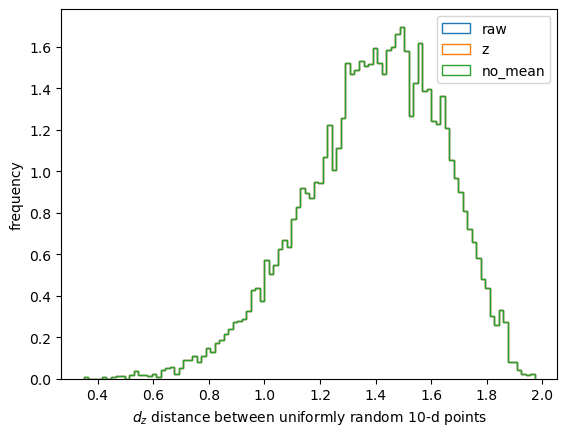

In [27]:
dists = defaultdict(list)
for _ in tqdm(range(SAMPLES)):
    vecs = np.random.rand(2,DIMS)*37 - 18.5

    try:
        dists["raw"].append(d(*vecs))
        dists["z"].append(d(*zscore(vecs,axis=1)))
    
        vecs_no_mean = vecs - vecs.sum(axis=0)
        dists["no_mean"].append(d(*vecs_no_mean))        
    except NoVarianceError:
        pass

for k,v in dists.items():
    plt.hist(v,density=True,histtype="step", label=k, bins=100)
plt.legend()
plt.xlabel(f"$d_z$ distance between uniformly random {DIMS}-d points")
plt.ylabel("frequency")
plt.show()

In [28]:
lb = defaultdict(list)
for _ in tqdm(range(SAMPLES)):
    vecs = np.random.rand(4,DIMS)*37 - 18.5
    x,y,z,_ = vecs
    lb["triangle"].append(np.abs(d(x,y) - d(z, y)))

    p1, p2, q, o = vecs
    numerator = d(p1,o)*d(p2,q) - d(p1,q)*d(p2,o)
    quotient = d(p1,p2)
    lb["ptolemy"].append(np.abs(numerator)/quotient)

    p1, p2, q, o = vecs
    p1_lb = np.abs(d(p1,o) - d(p1, q))
    p2_lb = np.abs(d(p2,o) - d(p2, q))
    lb["two_triangle"].append(max(p1_lb, p2_lb))

100%|███████████████████████████| 10000/10000 [00:02<00:00, 4531.44it/s]


overlaps
triangle 0.0389
ptolemy 0.103
two_triangle 0.0557
max_lb 0.1141


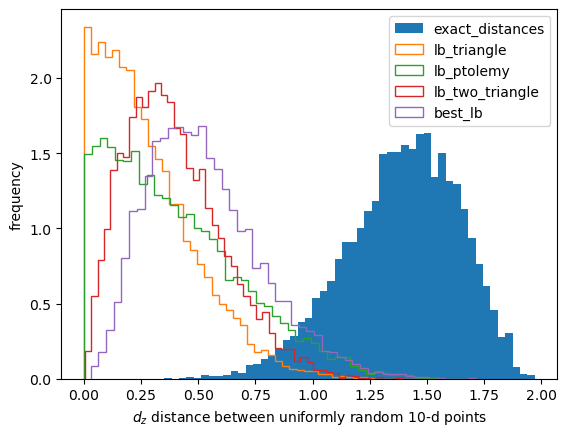

In [29]:
exact_dists = dists["raw"]
plt.hist(exact_dists,density=True,label="exact_distances", bins=50)

print("overlaps")
for k,v in lb.items():
    plt.hist(v,density=True,histtype="step", label="lb_"+k, bins=50)
    print(k,histogram_overlap(v,exact_dists))

# best of all
everything = np.asarray([v for _,v in lb.items()])
best = everything.max(axis=0)
plt.hist(best,density=True,histtype="step", label="best_lb", bins=50)
print("max_lb",histogram_overlap(best,exact_dists))

plt.legend()
plt.xlabel(f"$d_z$ distance between uniformly random {DIMS}-d points")
plt.ylabel("frequency")
plt.show()

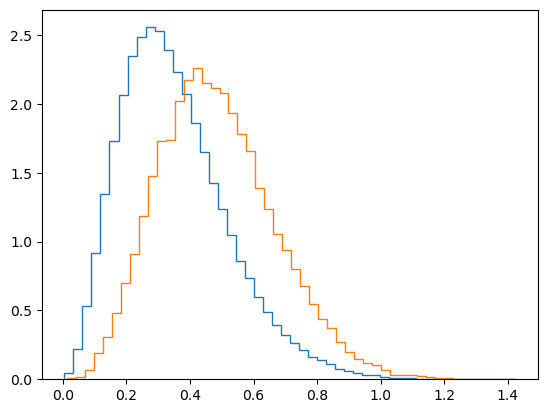

In [155]:
# using four pivots:
# we can do that because points are uniformly random
pto_4_piv = np.array(lb["ptolemy"]).reshape(4,-1)
pto_4_piv = pto_4_piv.max(axis=0)
plt.hist(best,density=True,histtype="step", label="best_lb", bins=50)
plt.hist(pto_4_piv,density=True,histtype="step", label="pto_4_piv", bins=50);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39682.43it/s]


(array([   3.,    4.,    8.,    9.,   17.,   29.,   37.,   47.,   56.,
          53.,   78.,   80.,   81.,  129.,  123.,  157.,  151.,  188.,
         214.,  222.,  261.,  283.,  290.,  303.,  344.,  308.,  360.,
         390.,  392.,  435.,  460.,  512.,  546.,  605.,  605.,  607.,
         611.,  666.,  711.,  749.,  745.,  820.,  819.,  879.,  880.,
         916.,  963., 1043., 1058., 1077., 1177., 1167., 1187., 1186.,
        1294., 1260., 1399., 1415., 1346., 1395., 1490., 1528., 1563.,
        1602., 1568., 1607., 1657., 1725., 1798., 1747., 1811., 1843.,
        1776., 1887., 1930., 1988., 1929., 1920., 1897., 1872., 1935.,
        1950., 1921., 1860., 1962., 1898., 1843., 1890., 1803., 1754.,
        1671., 1696., 1584., 1444., 1474., 1310., 1203., 1077.,  899.,
         538.]),
 array([0.02869428, 0.0484064 , 0.06811852, 0.08783064, 0.10754276,
        0.12725488, 0.14696701, 0.16667913, 0.18639125, 0.20610337,
        0.22581549, 0.24552761, 0.26523973, 0.28495186, 0.30466398

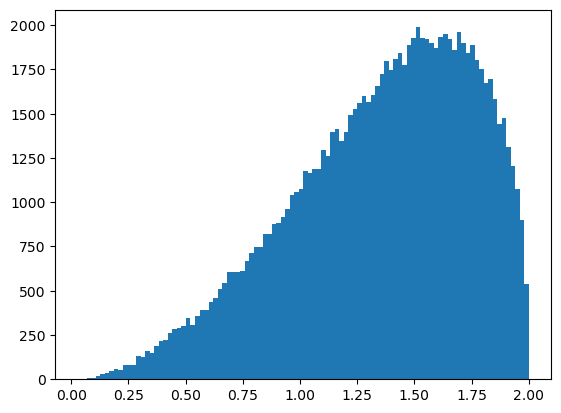

In [34]:
dists = []
for _ in tqdm(range(100000)):
    vecs = np.random.randint(-20, 20, size=[2,5])
    #vecs = zscore(vecs,axis=1) 
    dists.append(d(*vecs))

plt.hist(dists, bins=100)

In [9]:
dists = []
for _ in tqdm(range(100000)):
    vecs = np.random.randint(-20, 20, size=[4,5])
    vecs = zscore(vecs,axis=1) 
    x,y,z,k = vecs
    try:
        if triangle_violation(x,y,z) > 1e-3:
            print(x,y,z)
        if pto_violation(x,y,z,k) > 1e-3:
            print("pto violation", x,y,z)
    except ValueError:
        pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:21<00:00, 4752.37it/s]


In [12]:
for _ in tqdm(range(100000)):
    vecs = np.random.randint(-20, 20, size=[4,5])
    #vecs = vecs - vecs.mean(axis=0)
    x,y,z,k = vecs
    if triangle_violation(x,y,z) > 1e-3:
        print(x,y,z)
    if pto_violation(x,y,z,k) > 1e-3:
        print("pto violation", x,y,z)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:18<00:00, 5434.61it/s]


In [28]:
def cos_dist_triangle_inequality(x,y,z):
    def d_t(a,b):
        return np.sqrt(2- 2*cos_theta(a,b))
    lhs = d_t(x,y)
    rhs = d_t(x,z) + d_t(z,y)
    # lhs <= rhs
    violation = lhs - rhs
    return violation

side_diffs = []
for _ in tqdm(range(100000)):
    vecs = np.random.randint(-20, 20, size=[4,3])
    vecs = vecs / np.linalg.norm(vecs, axis=0)#- vecs.mean(axis=0)
    x,y,z,k = vecs
    diff = cos_dist_triangle_inequality(x,y,z)
    side_diffs.append(diff)
    if diff > 1e-3:
        print(diff, x,y,z)
        break


 11%|██████████▉                                                                                        | 11087/100000 [00:00<00:02, 37830.62it/s]/tmp/ipykernel_62546/1962127311.py:3: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2- 2*cos_theta(a,b))
 19%|██████████████████▉                                                                                | 19141/100000 [00:00<00:02, 39339.04it/s]/tmp/ipykernel_62546/2887405472.py:11: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(x*y,axis=0) / x_n / y_n
100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39793.32it/s]


(array([  275.,  1115.,  3037.,  6273., 10922., 16371., 18036., 16911.,
        15770., 11281.]),
 array([-3.90130221, -3.51117199, -3.12104177, -2.73091155, -2.34078133,
        -1.95065111, -1.56052088, -1.17039066, -0.78026044, -0.39013022,
         0.        ]),
 <BarContainer object of 10 artists>)

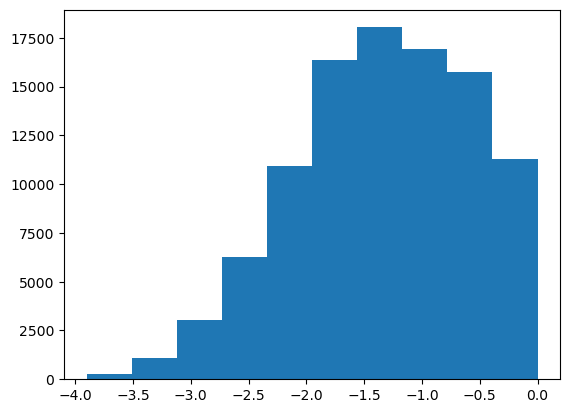

In [29]:
import matplotlib.pyplot as plt

plt.hist(side_diffs)

In [107]:
def d(corr, m=10):
    return np.sqrt(2*m*(1-corr))

def is_triangle_inequal(x_var, y_var, z_var, xy_cov, xz_cov, yz_cov):
    xy_corr = xy_cov / np.sqrt(x_var * y_var)
    xz_corr = xz_cov / np.sqrt(x_var * z_var)
    yz_corr = yz_cov / np.sqrt(z_var * y_var)
    return d(xy_cov) <= d(xz_cov) + d(yz_cov)

In [108]:
for _ in tqdm(range(10000)):
    vars = np.random.rand(3) * 100
    covars = (np.random.rand(3) - 0.5) * 100
    if not is_triangle_inequal(*vars, *covars):
        print("violation")
        break

  0%|                                                                                                                   | 0/10000 [00:00<?, ?it/s]

violation


In [ ]:
import numpy.linalg 

In [129]:
x,y = np.random.randint(-20, 20, size=[2,5])
x,y = x-np.mean(x), y-np.mean(y)

corr(x,y), cos_theta(x,y)

(-0.3830218630158735, -0.3830218630158734)

In [130]:
np.linalg.norm(x)

22.829805080201623

In [134]:
while True:
    x,y = np.random.randint(-20, 20, size=[2,4])
    if np.abs(corr(x,y)) < 1e-5:
        break

In [135]:
x,y, corr(x,y)

(array([-16, -16, -11,  19]), array([ 3, 18, -2,  8]), 0.0)

In [139]:
zscore(x), zscore(y)

(array([-0.68599434, -0.68599434, -0.34299717,  1.71498585]),
 array([-0.50709255,  1.52127766, -1.18321596,  0.16903085]))

In [140]:
d(x,y)

1.4142135623730951